#### Setup

In [46]:
# tokenization
import json
import MeCab
import demoji
import re
from stop_words import stop_words

# word2vec
import gensim, logging

# plotting
from sklearn.manifold import TSNE               
import numpy as np                
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#### Clean and Tokenize Tweets

In [13]:
# tokenize with mecab
mt = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")

# dataset we are working with
year = "2015"

# store results and exception tweets
tokens = []
retweets = []
not_parsed = []

# iterate through tweets
with open(year + '-all.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
    
        if line == None or tweet == None:
            not_parsed.append((line, tweet))
            print("Parsing error: ", line, tweet)
        elif tweet['retweetedTweet']:
            retweets.append(tweet)
            print("Retweet: ", tweet['id'])
        else: 
            # clean tweet content
            tweet_text = tweet['rawContent'] # note: need other prop for over 140 char?
            remove_emojis = demoji.replace(tweet_text, "")
            remove_more_emojis = re.sub("([\uD83E-\uD83E])+", "", remove_emojis)
            remove_newlines = re.sub("(\n)+", "", remove_more_emojis)
            remove_usernames = re.sub("@([a-zA-Z0-9_]+)", "", remove_newlines)
            remove_hashtags = re.sub("#([a-zA-Z0-9_ぁ-んァ-ン一-龠]+)", "", remove_usernames)
            remove_links = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", remove_hashtags)
            remove_punc = re.sub("([-.,;\"\'!?~@#$%^&*():\{\}\[\]\/\\\\]+)", "", remove_links)
            remove_jp_punc = re.sub("([\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\uFF9E-\uFFEE\u3000-\u303F]+)", "", remove_punc)
            remove_geo_shapes = re.sub("([\u25A0-\u25FF])+", "", remove_jp_punc)
            remove_misc_symbols = re.sub("([\u2600-\u26FF])+", "", remove_geo_shapes)

            # tokenize with mecab
            parsed = mt.parseToNode(remove_misc_symbols)
            components = []
            while parsed:
                components.append(parsed.surface)
                parsed = parsed.next
            components = [token for token in components if not token in stop_words]
            tokens.append(components)

file.close()

In [14]:
# did we get retweets, or did twscrape filter them out?
print(len(retweets))

# did any tweets fail parsing?
print(len(not_parsed))

0
0


#### Word2Vec

In [15]:
# set up logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# train word2vec model
model = gensim.models.Word2Vec(tokens, min_count=10)

2023-11-30 11:45:01,537 : INFO : collecting all words and their counts
2023-11-30 11:45:01,538 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-11-30 11:45:01,570 : INFO : PROGRESS: at sentence #10000, processed 114228 words, keeping 24650 word types
2023-11-30 11:45:01,604 : INFO : PROGRESS: at sentence #20000, processed 231458 words, keeping 34938 word types
2023-11-30 11:45:01,632 : INFO : PROGRESS: at sentence #30000, processed 339402 words, keeping 46351 word types


2023-11-30 11:45:01,658 : INFO : PROGRESS: at sentence #40000, processed 453140 words, keeping 55661 word types
2023-11-30 11:45:01,700 : INFO : PROGRESS: at sentence #50000, processed 565107 words, keeping 63789 word types
2023-11-30 11:45:01,733 : INFO : PROGRESS: at sentence #60000, processed 674237 words, keeping 66590 word types
2023-11-30 11:45:01,756 : INFO : PROGRESS: at sentence #70000, processed 784038 words, keeping 67884 word types
2023-11-30 11:45:01,779 : INFO : PROGRESS: at sentence #80000, processed 898438 words, keeping 68752 word types
2023-11-30 11:45:01,806 : INFO : PROGRESS: at sentence #90000, processed 1033998 words, keeping 77940 word types
2023-11-30 11:45:01,839 : INFO : PROGRESS: at sentence #100000, processed 1143976 words, keeping 84003 word types
2023-11-30 11:45:01,864 : INFO : PROGRESS: at sentence #110000, processed 1253336 words, keeping 87153 word types
2023-11-30 11:45:01,888 : INFO : PROGRESS: at sentence #120000, processed 1363467 words, keeping 92

In [16]:
# save word2vec model
model.save("thesis_w2v_" + year + "_tweets")

2023-11-30 11:45:19,091 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'thesis_w2v_2015_tweets', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-11-30T11:45:19.091673', 'gensim': '4.3.2', 'python': '3.11.5 (main, Aug 24 2023, 15:18:16) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5-x86_64-i386-64bit', 'event': 'saving'}
2023-11-30 11:45:19,098 : INFO : not storing attribute cum_table
2023-11-30 11:45:19,182 : INFO : saved thesis_w2v_2015_tweets


In [21]:
# load trained word2vec model
model_2015 = gensim.models.Word2Vec.load("thesis_w2v_" + year + "_tweets")

2023-11-30 11:55:40,027 : INFO : loading Word2Vec object from thesis_w2v_2015_tweets
2023-11-30 11:55:40,106 : INFO : loading wv recursively from thesis_w2v_2015_tweets.wv.* with mmap=None
2023-11-30 11:55:40,107 : INFO : setting ignored attribute cum_table to None
2023-11-30 11:55:40,346 : INFO : Word2Vec lifecycle event {'fname': 'thesis_w2v_2015_tweets', 'datetime': '2023-11-30T11:55:40.346216', 'gensim': '4.3.2', 'python': '3.11.5 (main, Aug 24 2023, 15:18:16) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5-x86_64-i386-64bit', 'event': 'loaded'}


In [22]:
# check similarity given by trained model
print(model_2015.wv.most_similar(positive='在日',topn=10))
print(model_2015.wv.most_similar(positive='外国人',topn=10))


[('侵攻', 0.8870046734809875), ('破る', 0.8761901259422302), ('人民', 0.8755786418914795), ('岸田文雄', 0.8644543886184692), ('自公', 0.8606095910072327), ('右派', 0.8567697405815125), ('起訴', 0.854092538356781), ('立民', 0.8535529971122742), ('プロパガンダ', 0.8532180786132812), ('朝鮮人', 0.8528974056243896)]
[('日本人', 0.8911892771720886), ('中国人', 0.8543750643730164), ('若者', 0.8528403639793396), ('他国', 0.8411896824836731), ('政治', 0.8321614861488342), ('国', 0.8315311670303345), ('高齢者', 0.8311120867729187), ('移民', 0.8291254639625549), ('国会議員', 0.828331708908081), ('職員', 0.8269411325454712)]


#### Plot Word2Vec Findings

In [43]:
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

def reduce_dimensions(model):
    num_dimensions = 2

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model_2015)

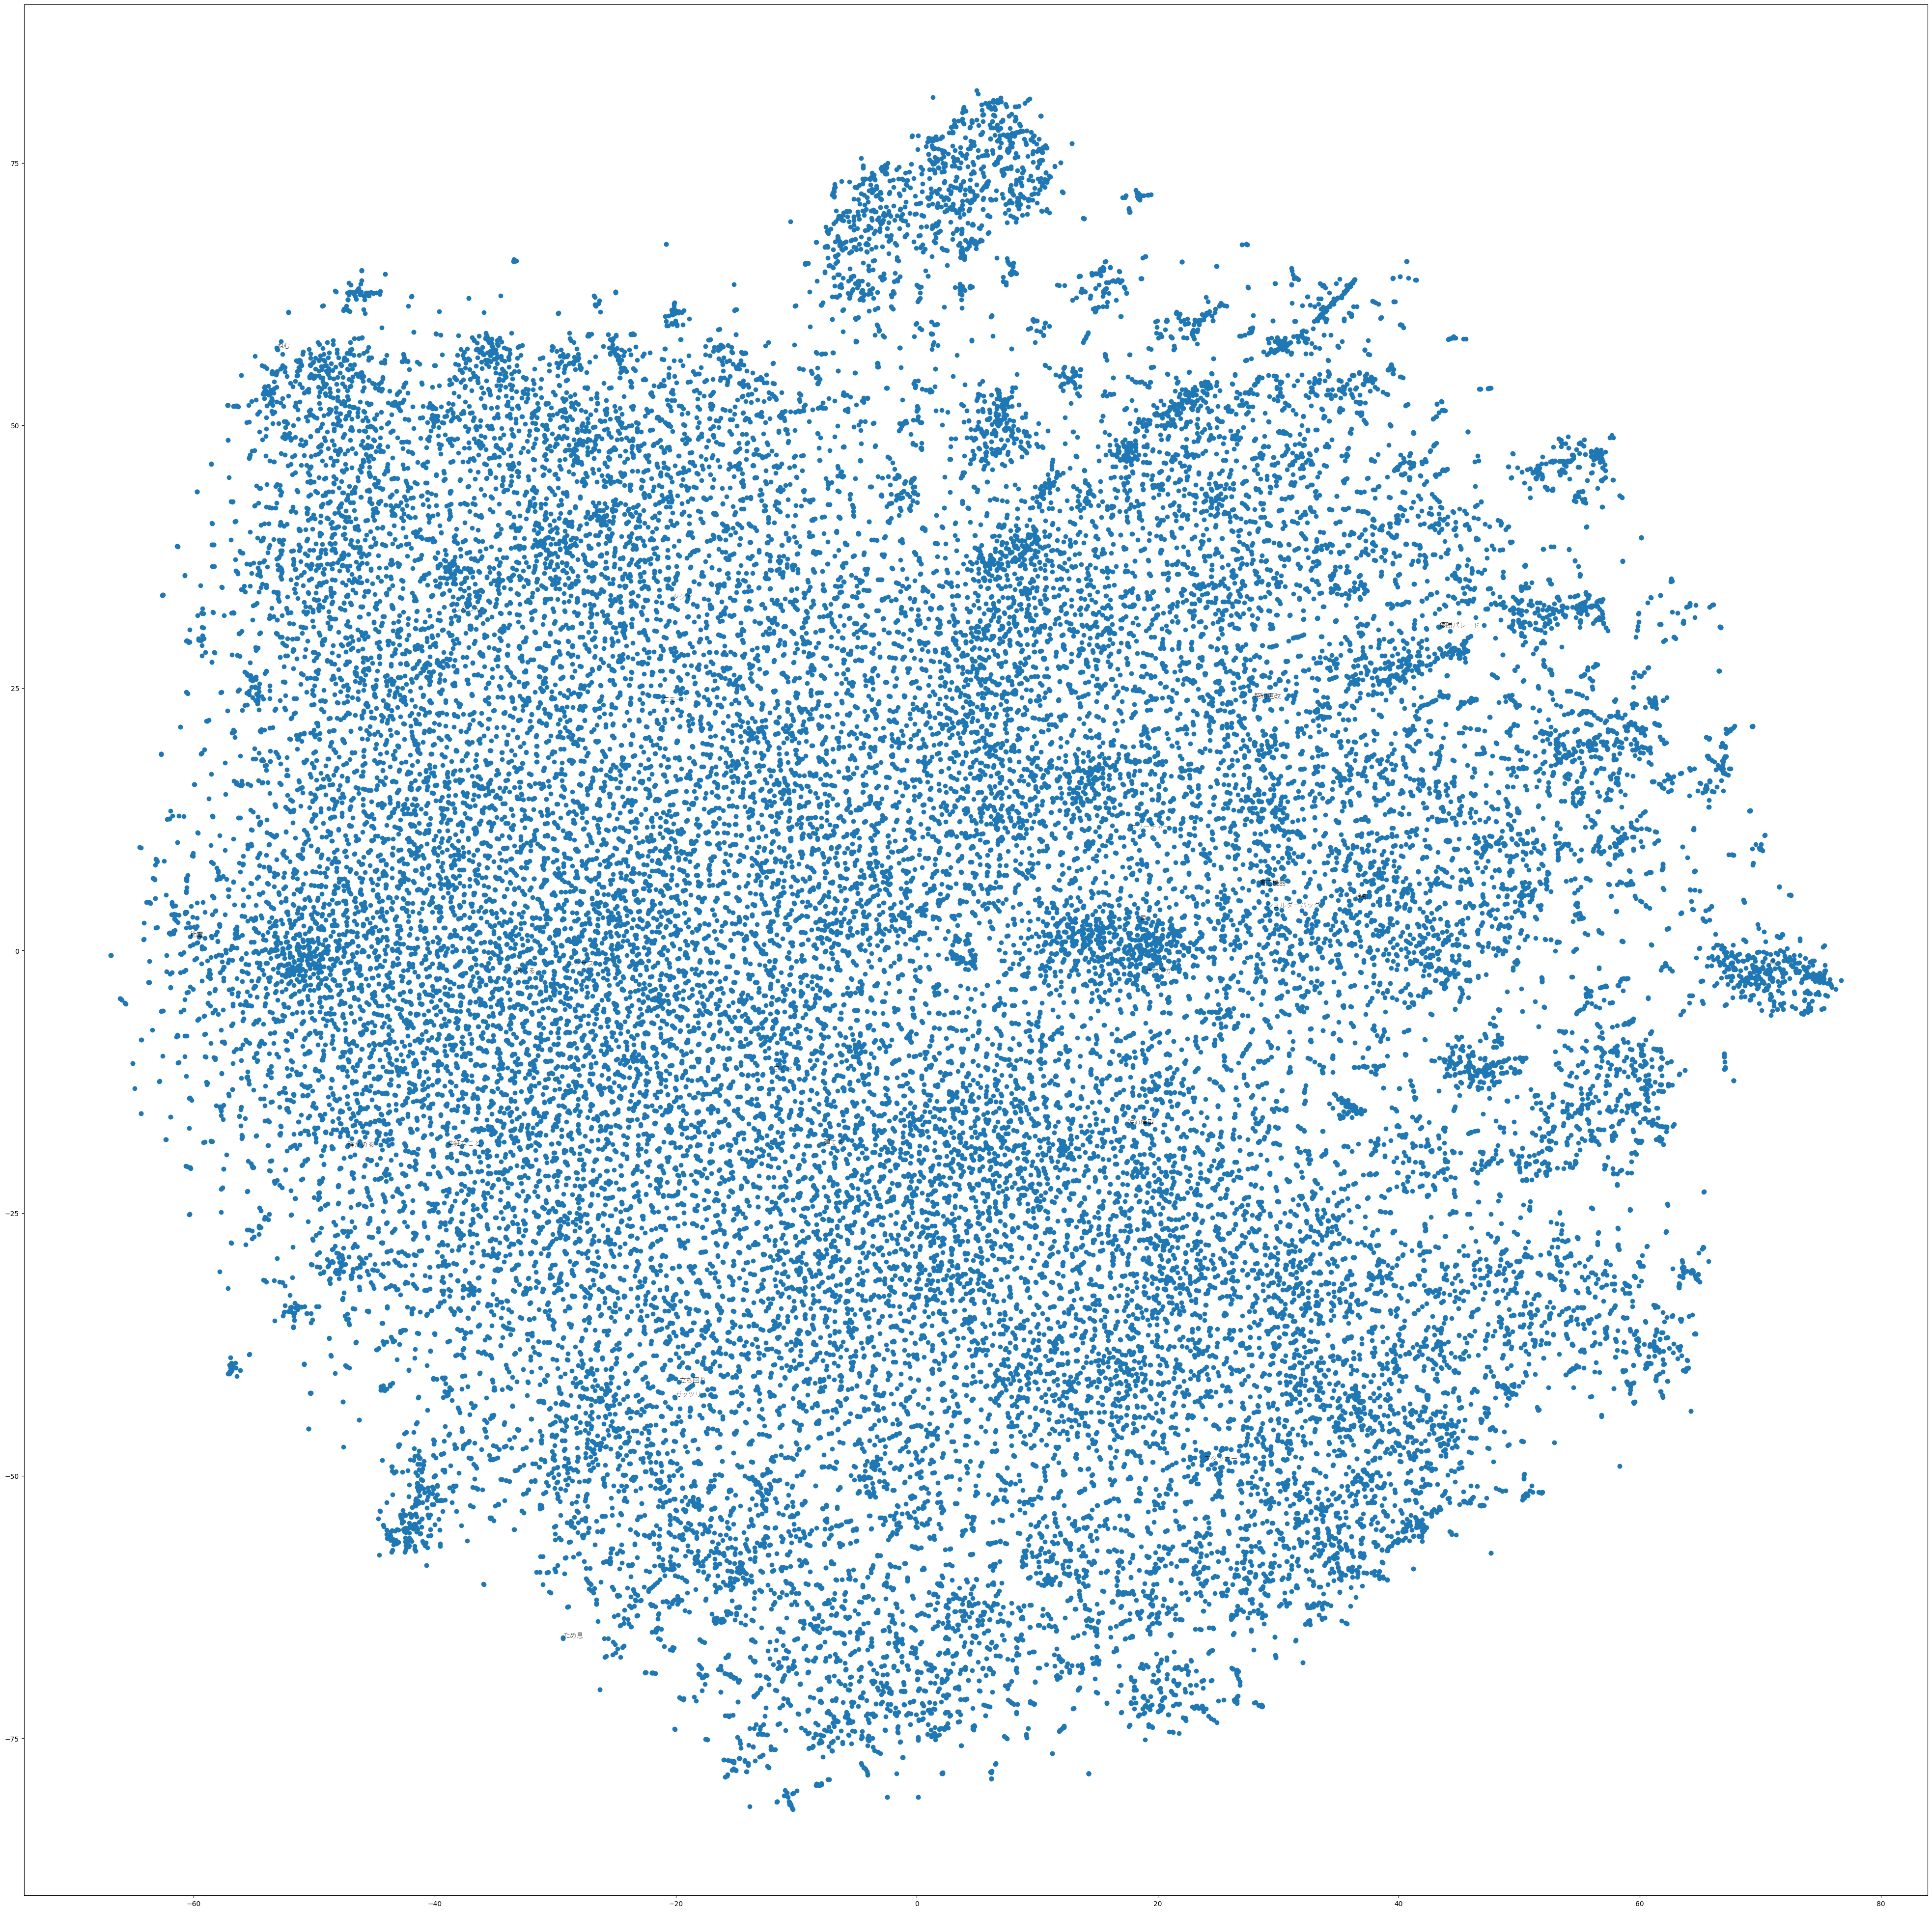

In [52]:
# this plots all words; isn't very useful

# https://albertauyeung.github.io/2020/03/15/matplotlib-cjk-fonts.html/

def plot_word2vec(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(50, 50))
    plt.scatter(x_vals, y_vals)

    # label randomly subsampled 25 data points
    fprop = fm.FontProperties(fname='NotoSansJP-VariableFont_wght.ttf')
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]), fontproperties=fprop)

plot_word2vec(x_vals, y_vals, labels)

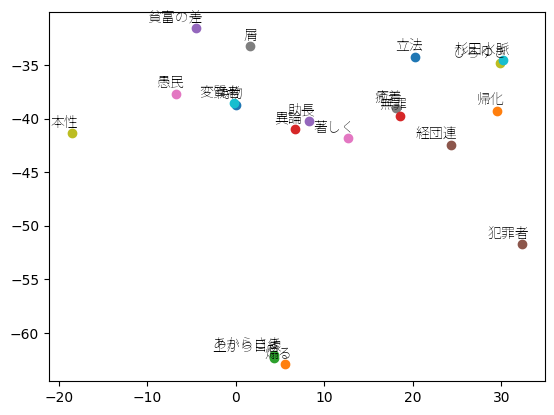

In [68]:
# instead, plot similar words only

# https://aneesha.medium.com/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229 
# https://albertauyeung.github.io/2020/03/15/matplotlib-cjk-fonts.html/
# https://stackoverflow.com/questions/70268270/how-to-plot-tsne-on-word2vec-created-from-gensim-for-the-most-similar-20-cases

def plot_closest_words(word, model):
    labels = [i for i in model.wv.index_to_key]
    close_words = [i[0] for i in model.wv.most_similar(positive=word, topn=20)]

    # plot 
    fprop = fm.FontProperties(fname='NotoSansJP-VariableFont_wght.ttf')
    for word in close_words:
        i = labels.index(word)
        plt.scatter(x_vals[i],y_vals[i])
        plt.annotate(labels[i], xy=(x_vals[i], y_vals[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontproperties=fprop)

plot_closest_words("外人", model_2015)